In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil

In [ ]:
from google.colab import drive

drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 33.40 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [ ]:
for line in open('/content/IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
  img_name, label = line.split('\t')[:2]
  dest = '/content/IMagenet/tiny-imagenet-200/valid/'+label
  os.makedirs(dest, exist_ok=True)
  shutil.copy('/content/IMagenet/tiny-imagenet-200/val/images/'+img_name,os.path.join(dest,img_name))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128
target_size = (85, 85)

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        '/content/IMagenet/tiny-imagenet-200/train',  
        target_size=target_size,  
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/content/IMagenet/tiny-imagenet-200/valid',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        color_mode='rgb',
        class_mode='categorical')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


**ResNet**

In [ ]:
feature_extractor_Resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Resnet.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 85, 85, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 91, 91, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 43, 43, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 43, 43, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
for layer in feature_extractor_Resnet.layers:
    layer.trainable = False

feature_extractor_Resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 85, 85, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 91, 91, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 43, 43, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 43, 43, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Flatten

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Resnet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 85, 85, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 200)               3686600   
                                                                 
Total params: 27,274,312
Trainable params: 3,686,600
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

Epoch 1/10
782/782 [==============================] - 91s 100ms/step - loss: 8.7984 - acc: 0.2770 - val_loss: 9.2778 - val_acc: 0.3253
Epoch 2/10
782/782 [==============================] - 74s 95ms/step - loss: 4.0994 - acc: 0.5499 - val_loss: 10.2509 - val_acc: 0.3274
Epoch 3/10
782/782 [==============================] - 75s 95ms/step - loss: 2.5125 - acc: 0.6787 - val_loss: 10.5688 - val_acc: 0.3521
Epoch 4/10
782/782 [==============================] - 74s 95ms/step - loss: 1.7173 - acc: 0.7611 - val_loss: 11.6636 - val_acc: 0.3532
Epoch 5/10
782/782 [==============================] - 74s 95ms/step - loss: 1.4690 - acc: 0.7987 - val_loss: 12.6928 - val_acc: 0.3607
Epoch 6/10
782/782 [==============================] - 74s 95ms/step - loss: 1.2652 - acc: 0.8281 - val_loss: 13.5292 - val_acc: 0.3697
Epoch 7/10
782/782 [==============================] - 75s 96ms/step - loss: 1.1480 - acc: 0.8492 - val_loss: 14.8242 - val_acc: 0.3687
Epoch 8/10
782/782 [==============================] - 7

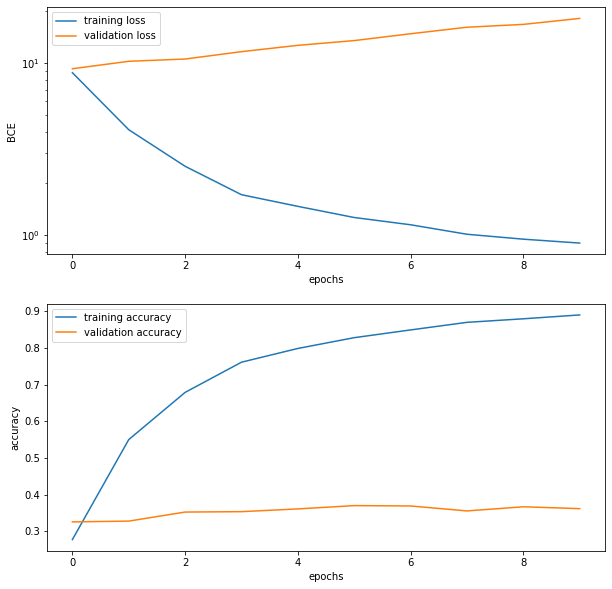

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator.classes

In [ ]:
from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred_valid_Resnet = model.predict(validation_generator)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_Resnet.argmax(axis=1))

print(cls_report)

              precision    recall  f1-score   support

           0       0.44      0.76      0.56        50
           1       0.58      0.58      0.58        50
           2       0.18      0.12      0.14        50
           3       0.19      0.18      0.19        50
           4       0.35      0.30      0.32        50
           5       0.24      0.10      0.14        50
           6       0.93      0.28      0.43        50
           7       0.19      0.14      0.16        50
           8       0.58      0.56      0.57        50
           9       0.31      0.36      0.33        50
          10       0.85      0.22      0.35        50
          11       0.45      0.28      0.35        50
          12       0.70      0.42      0.53        50
          13       0.57      0.72      0.64        50
          14       0.59      0.74      0.65        50
          15       0.70      0.14      0.23        50
          16       0.08      0.46      0.13        50
          17       0.58    

In [ ]:
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_Resnet.argmax(axis=1))
print(cnf)

[[38  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 0  2  6 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  5  0]
 [ 0  0  0 ...  5 29  0]
 [ 0  0  0 ...  0  0 15]]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128
target_size = (85, 85)

train_datagen2 = ImageDataGenerator( rotation_range=10,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    channel_shift_range=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1./255)

test_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        '/content/IMagenet/tiny-imagenet-200/train',  
        target_size=target_size,  
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator2 = test_datagen2.flow_from_directory(
        '/content/IMagenet/tiny-imagenet-200/valid',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


**Resnet without transfer learning**

In [ ]:
feature_extractor_Resnet = tf.keras.applications.resnet50.ResNet50(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 85, 85, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 91, 91, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 43, 43, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 43, 43, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Resnet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 85, 85, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 200)               3686600   
                                                                 
Total params: 27,274,312
Trainable params: 27,221,192
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

Epoch 1/10
782/782 [==============================] - 234s 290ms/step - loss: 5.2717 - acc: 0.0552 - val_loss: 4.5103 - val_acc: 0.0898
Epoch 2/10
782/782 [==============================] - 225s 288ms/step - loss: 3.8576 - acc: 0.1666 - val_loss: 5.9357 - val_acc: 0.1308
Epoch 3/10
782/782 [==============================] - 225s 288ms/step - loss: 3.3114 - acc: 0.2527 - val_loss: 4.2761 - val_acc: 0.1860
Epoch 4/10
782/782 [==============================] - 225s 288ms/step - loss: 2.9036 - acc: 0.3250 - val_loss: 3.9582 - val_acc: 0.1962
Epoch 5/10
782/782 [==============================] - 226s 288ms/step - loss: 2.5124 - acc: 0.3959 - val_loss: 7.0794 - val_acc: 0.1887
Epoch 6/10
782/782 [==============================] - 226s 288ms/step - loss: 2.1037 - acc: 0.4767 - val_loss: 5.1515 - val_acc: 0.2493
Epoch 7/10
782/782 [==============================] - 225s 288ms/step - loss: 1.5801 - acc: 0.5899 - val_loss: 7.2899 - val_acc: 0.2634
Epoch 8/10
782/782 [============================

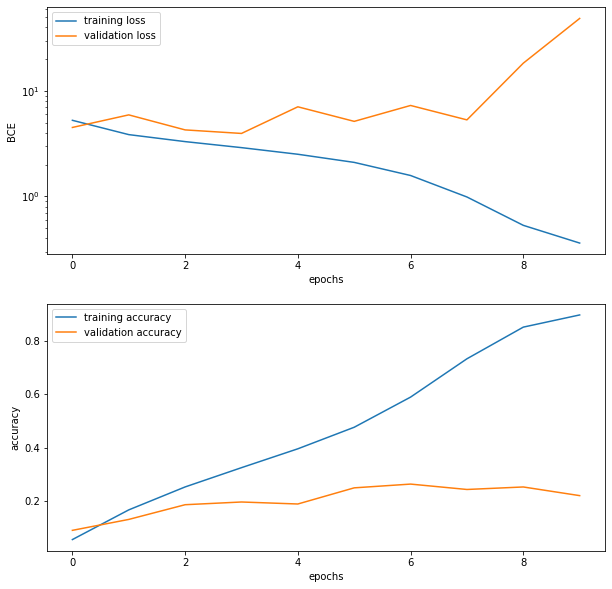

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_resnet = model.predict(validation_generator)

from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_resnet.argmax(axis=1))

print(cls_report)

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        50
           1       0.72      0.36      0.48        50
           2       0.34      0.20      0.25        50
           3       0.25      0.08      0.12        50
           4       0.21      0.14      0.17        50
           5       0.09      0.08      0.09        50
           6       0.78      0.14      0.24        50
           7       0.21      0.10      0.14        50
           8       0.74      0.40      0.52        50
           9       0.13      0.10      0.11        50
          10       0.18      0.06      0.09        50
          11       0.27      0.34      0.30        50
          12       0.39      0.28      0.33        50
          13       0.42      0.10      0.16        50
          14       0.50      0.18      0.26        50
          15       0.46      0.12      0.19        50
          16       0.00      0.00      0.00        50
          17       0.67    

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_resnet.argmax(axis=1))
print(cnf)

[[25  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  1]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  1  0]
 [ 1  0  0 ...  2  8  0]
 [ 0  0  0 ...  0  0  3]]


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Flatten

**Inception v3**

In [ ]:
feature_extractor_Inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Inception_v3.summary()

In [ ]:
for layer in feature_extractor_Inception_v3.layers[0:-2]:
    layer.trainable = False

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Inception_v3(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 85, 85, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               409800    
                                                                 
Total params: 22,212,584
Trainable params: 409,800
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_inception = model.predict(validation_generator2)

from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_inception.argmax(axis=1))

print(cls_report)



In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_inception.argmax(axis=1))
print(cnf)

**inception without transfer learning**

In [ ]:
feature_extractor_Inception_v3 = tf.keras.applications.efficientnet.EfficientNetB7(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Inception_v3.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Inception_v3(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator,
                    epochs = 7,
                    validation_data=validation_generator)

**Efficientnet**

In [ ]:
feature_extractor_efficientnet = tf.keras.applications.efficientnet.EfficientNetB7(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_efficientnet.summary()

In [ ]:
for layer in feature_extractor_efficientnet.layers[0:-2]:
    layer.trainable = False

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_efficientnet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_efficientnet = model.predict(validation_generator)

from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_efficientnet.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_efficientnet.argmax(axis=1))
print(cnf)

**Efficientnet without transfer learning**

In [ ]:
feature_extractor_efficientnet = tf.keras.applications.efficientnet.EfficientNetB7(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_efficientnet.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_efficientnet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 7,
                    validation_data=validation_generator2)

**Densenet**

In [ ]:
feature_extractor_dencenet = tf.keras.applications.DenseNet121(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_dencenet.summary()

In [ ]:
for layer in feature_extractor_dencenet.layers[0:-2]:
    layer.trainable = False

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_dencenet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_dencenet = model.predict(validation_generator2)

from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_dencenet.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_dencenet.argmax(axis=1))
print(cnf)

In [ ]:
model.save('/content/drive/MyDrive/hw3_model/dencenet/dencenet.h5')


**Dencenet without transfer learning**

In [ ]:
feature_extractor_dencenet = tf.keras.applications.DenseNet121(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_dencenet.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_dencenet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 7,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_densenet = model.predict(validation_generator2)

from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_densenet.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_densenet.argmax(axis=1))
print(cnf)

**Mobile net**

In [ ]:
feature_extractor_Mobilenet = tf.keras.applications.MobileNetV2(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Mobilenet.summary()

In [ ]:
for layer in feature_extractor_Mobilenet.layers:
    layer.trainable = False

feature_extractor_Mobilenet.summary()

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Flatten

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Mobilenet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_Mobilenet = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_Mobilenet.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_Mobilenet.argmax(axis=1))
print(cnf)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(cnf)

**Mobilenet withput transfer learning**

In [ ]:
feature_extractor_Mobilenet = tf.keras.applications.MobileNetV2(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Mobilenet.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Mobilenet(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_mobilenet = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_mobilenet.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_mobilenet.argmax(axis=1))
print(cnf)

**VGG 19**

In [ ]:
feature_extractor_vgg19 = tf.keras.applications.vgg19.VGG19(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_vgg19.summary()

In [ ]:
for layer in feature_extractor_vgg19.layers[0:-2]:
    layer.trainable = False

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_vgg19(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 15,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_VGG19 = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_VGG19.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_VGG19.argmax(axis=1))
print(cnf)

**VGG19 without transfer learning**

In [ ]:
feature_extractor_vgg19 = tf.keras.applications.vgg19.VGG19(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_vgg19.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_vgg19(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)


In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 7,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_vgg19 = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_vgg19.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_vgg19.argmax(axis=1))
print(cnf)

**Xception**

In [ ]:
feature_extractor_Xception = tf.keras.applications.Xception(weights='imagenet'
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Xception.summary()

In [ ]:
for layer in feature_extractor_Xception.layers[0:-2]:
    layer.trainable = False

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Xception(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 15,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_xception = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_xception.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_xception.argmax(axis=1))
print(cnf)

**Xception without transfer learning**

In [ ]:
feature_extractor_Xception = tf.keras.applications.Xception(weights=None
                                      , input_shape=(85, 85, 3) ,include_top=False)
feature_extractor_Xception.summary()

In [ ]:
inp_layer = Input(shape = (85, 85, 3))
features = feature_extractor_Xception(inp_layer)
flat = Flatten()(features)
output = Dense(units = 200, activation = 'softmax')(flat)

model = Model(inputs = inp_layer, outputs = output)

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.001)
BCE = categorical_crossentropy
model.compile(optimizer = opt, loss=BCE, metrics = 'acc')

In [ ]:
results = model.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('BCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
y_hat = validation_generator2.classes

from tensorflow.keras.utils import to_categorical
y_hat = to_categorical(y_hat,num_classes = 200)

y_pred_valid_xception = model.predict(validation_generator2)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_hat.argmax(axis=1), y_pred_valid_xception.argmax(axis=1))

print(cls_report)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_hat.argmax(axis=1), y_pred_valid_xception.argmax(axis=1))
print(cnf)